In [2]:
import pandas as pd
from statsbombpy import sb
import matplotlib.font_manager as font_manager
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import matplotlib.patches as patches
import warnings
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec



In [313]:
matches_df = sb.matches(competition_id=9, season_id=281)

competition = [comp.rsplit(maxsplit=1)[-1] for comp in matches_df['competition'].unique()][0]
season = [seas.replace("/", "-") for seas in matches_df['season'].unique()][0]

background_color = '#f7f8f3'
text_color = '#464033'
sec_color = '#868B8E'

font_path = "C:/Users/jerry/Documents/Personal/09 Repositories/fonts/Roboto/Roboto-Black.ttf"
font_props = font_manager.FontProperties(fname=font_path)

warnings.filterwarnings("ignore", category=UserWarning, module="statsbombpy")



In [4]:
sb.competitions()
matches_df = sb.matches(competition_id=9, season_id=281)

In [248]:
def process_data(player_name):
    """
    Process passing data for a specific player across multiple matches.

    Args:
        player_name (str): The name of the player to filter passing data for.

    Returns:
        pd.DataFrame: A DataFrame containing all valid passes made by the player.
    """
    
    # Initialize an empty DataFrame to store passes across all matches
    allpass_df = pd.DataFrame()

    # Loop through each match ID in the match_ids list
    for i in match_ids:
        # Fetch event data for the given match ID using StatsBomb API
        event_df = sb.events(match_id=i)

        # Extract and store the last name of the player
        event_df['player_lastname'] = event_df['player'].str.split().str[-1]
        # Extract and store the last name of the pass recipient
        event_df['pass_recipient_lastname'] = event_df['pass_recipient'].str.split().str[-1]

        # Filter the DataFrame to include only valid passes made by the player
        pass_df = event_df[
            (event_df.type == 'Pass') &  # Include only events of type 'Pass'
            (event_df.pass_type != 'Throw-in') &  # Exclude throw-ins
            (event_df.player == player_name) &  # Include only passes by the specified player
            (pd.isnull(event_df.pass_outcome))  # Exclude incomplete or failed passes
        ].reset_index(drop=True)  # Reset the index for the filtered DataFrame

        # Append the filtered passes to the overall DataFrame
        allpass_df = pd.concat([allpass_df, pass_df], ignore_index=True)

    # Return the consolidated DataFrame with all valid passes by the player
    return allpass_df


In [288]:
def pass_solarsystem(df,fig, ax):
    # Drop columns with all NaN values
    df.dropna(axis=1, how='all', inplace=True)

    # Extract start and end locations from the location and pass_end_location columns
    df[['sloc_x', 'sloc_y']] = pd.DataFrame(df['location'].tolist(), index=df.index)
    df[['eloc_x', 'eloc_y']] = pd.DataFrame(df['pass_end_location'].tolist(), index=df.index)

    # Transform the coordinates for a vertically oriented pitch
    # Reassign sloc and eloc coordinates by swapping x and y
    df['sloc_x'], df['sloc_y'] = df['sloc_y'], df['sloc_x']
    df['eloc_x'], df['eloc_y'] = df['eloc_y'], df['eloc_x']

    # Create a DataFrame to hold the pass network data
    passnetwork_df = pd.DataFrame(columns=['player', 'x', 'y', 'avg_pass_length', 'num_of_passes', 'norm_x', 'norm_y'])

    # Loop through each unique player to calculate their network statistics
    for name in df['pass_recipient_lastname'].unique():
        # Extract relevant data for each player
        recx = df.loc[df['pass_recipient_lastname'] == name, 'eloc_x'].to_numpy()
        recy = df.loc[df['pass_recipient_lastname'] == name, 'eloc_y'].to_numpy()
        passlength = df.loc[df['pass_recipient_lastname'] == name, 'pass_length'].to_numpy()
        
        # Append calculated stats to the passnetwork DataFrame
        passnetwork_df = pd.concat([
            passnetwork_df,
            pd.DataFrame({
                'player': [name],
                'x': [recx.mean()],  # Average x position
                'y': [recy.mean()],  # Average y position
                'avg_pass_length': [passlength.mean()],  # Average pass length
                'num_of_passes': [int(len(recx))],  # Total number of passes
                'norm_x': [recx.mean() / 120],  # Normalize x position for a pitch width of 120m
                'norm_y': [recy.mean() / 80]    # Normalize y position for a pitch height of 80m
            })
        ], ignore_index=True)

    # Convert num_of_passes to integers for consistency
    passnetwork_df['num_of_passes'] = passnetwork_df['num_of_passes'].astype(int)

    # Filter out players with fewer than the average number of passes
    avg_passes = round(passnetwork_df['num_of_passes'].mean(),0)
    passnetwork_df = passnetwork_df[passnetwork_df['num_of_passes'] >= avg_passes]

    # Define a scaling multiplier for visualization
    multiplier = 0.2

    # Identify the reference player (assumed as the central node)
    for name, group in df.groupby('player_lastname'):
        # Reference player is set as the single player in the group
        reference_player = {
            'player': name,
            'x': group['sloc_x'].mean(),  # Average x position
            'y': group['sloc_y'].mean(),  # Average y position
            'num_of_passes': len(group),  # Total passes by the reference player
            'norm_x': group['sloc_x'].mean() / 120,  # Normalize x position
            'norm_y': group['sloc_y'].mean() / 80,   # Normalize y position
            'recentered_x': 0,  # Placeholder for recentered x
            'recentered_y': 0,  # Placeholder for recentered y
            'scaled_x': 0,      # Placeholder for scaled x
            'scaled_y': 0       # Placeholder for scaled y
        }

    # Extract details of the reference player
    reference_player_name = reference_player['player']
    reference_x = reference_player['norm_x']
    reference_y = reference_player['norm_y']

    # Recenter player coordinates relative to the reference player
    passnetwork_df['recentered_x'] = passnetwork_df['norm_x'] - reference_x
    passnetwork_df['recentered_y'] = passnetwork_df['norm_y'] - reference_y

    # Scale the recentered coordinates by the average pass length
    passnetwork_df['scaled_x'] = passnetwork_df['recentered_x'] * passnetwork_df['avg_pass_length']
    passnetwork_df['scaled_y'] = passnetwork_df['recentered_y'] * passnetwork_df['avg_pass_length']

    # Compute the current distance of each player from the reference player
    passnetwork_df['distance'] = np.sqrt(passnetwork_df['recentered_x']**2 + passnetwork_df['recentered_y']**2)

    # Compute a scaling factor to adjust distances based on average pass length
    passnetwork_df['scaling_factor'] = passnetwork_df['avg_pass_length'] / passnetwork_df['distance']

    # Adjust the scaled coordinates by applying the multiplier
    passnetwork_df['scaled_x'] = passnetwork_df['recentered_x'] * passnetwork_df['scaling_factor'] * multiplier
    passnetwork_df['scaled_y'] = passnetwork_df['recentered_y'] * passnetwork_df['scaling_factor'] * multiplier

    # Create the graph
    G = nx.Graph()

    # Add the reference player as the central node
    G.add_node(reference_player_name, pos=(0, 0))  # Central node at (0, 0)

    # Add other players as nodes and connect them to the central node
    for _, row in passnetwork_df.iterrows():
        if row['player'] != reference_player_name:  # Avoid self-loops
            G.add_node(row['player'], pos=(row['scaled_x'], row['scaled_y']))
            G.add_edge(reference_player_name, row['player'])  # Connect to the central node

    # Extract positions for visualization
    pos = nx.get_node_attributes(G, 'pos')

    # Define node sizes based on the number of passes
    node_size = []
    for node in G.nodes:
        if node == reference_player_name:
            # Assign a size for the central node
            node_size.append(1000 + passnetwork_df['num_of_passes'].mean() * 20)
        else:
            # Assign size based on the number of passes
            row = passnetwork_df[passnetwork_df['player'] == node]
            node_size.append(800 + row.iloc[0]["num_of_passes"] * 5)

    # Define node colors
    node_color = ['#f89a1e' if node == reference_player_name else '#E32221' for node in G.nodes]

    # Define edge widths
    line_widths = [1.5 if node == reference_player_name else 0.8 for node in G.nodes]

    # Visualization
    fig.set_facecolor(background_color)

    # Draw nodes and edges
    nx.draw(
        G,
        pos,
        with_labels=False,
        node_size=node_size,
        node_color=node_color,
        edgecolors="black",
        linewidths=line_widths,
        width=3,
        edge_color="#F3E500",
        ax = ax,
    )

    # Add node labels with distinct font colors
    labels = {node: node for node in G.nodes}
    font_colors = ["black" if node == reference_player_name else "white" for node in G.nodes]
    for node, color in zip(G.nodes, font_colors):
        nx.draw_networkx_labels(
            G,
            pos,
            labels={node: labels[node]},
            font_color=color,
            font_family="Verdana",
            font_weight="bold",
            font_size=7,
        )

    # Calculate the maximum average pass length and round it to the nearest 5
    max_avg_pass_length = passnetwork_df['avg_pass_length'].max()
    farthest_distance = int(np.ceil(max_avg_pass_length / 5.0) * 5)  # Round up to the nearest 5

    # Generate distances dynamically: farthest distance, then -5, -6, -7, -8, -9, -10
    distances = [farthest_distance - offset for offset in [0, 5, 6, 7, 8, 9, 10]]

    # Ensure all distances are positive
    distances = [d for d in distances if d > 0]

    # Scale the radii using the multiplier
    circle_radii = [(distance * multiplier) for distance in distances]
    
    for i, (radius, distance) in enumerate(zip(circle_radii, distances)):
        circle = patches.Circle(
            (0, 0),  # Center at origin
            radius,
            color="black",
            fill=False,
            linestyle="dotted",
            linewidth=0.8,
            alpha=0.8,
        )
        plt.gca().add_artist(circle)
        
        # Add distance labels for specific circles
        if i == 0 or i == 1:  # Add labels for 15m and 20m circles
            plt.text(
                0, radius + 0.2,  # Place label slightly above the top of the circle
                f"{distance}m",
                fontsize=9,
                ha="center",
                va="center",
                fontproperties=font_props,
                rotation=0,
            )

    # Add directional labels
    directions = {
        "Forward": (0, max(circle_radii) + 0.5),
        "Backward": (0, -max(circle_radii) - 0.5),
        "Left": (-max(circle_radii) - 0.5, 0),
        "Right": (max(circle_radii) + 0.5, 0),
    }
    for label, (x, y) in directions.items():
        rotation = 0  # Default rotation for "Forward" and "Backward"
        if label == "Left":
            rotation = 90  # Rotate 90 degrees for "Left"
        elif label == "Right":
            rotation = -90  # Rotate -90 degrees for "Right"
        
        plt.text(
            x,
            y,
            label,
            fontsize=12,
            ha="center",
            va="center",
            fontproperties=font_props,
            rotation=rotation,  # Apply rotation
        )
                
    # Adjust plot limits for visualization
    max_distance = max((x**2 + y**2)**0.5 for x, y in pos.values())
    padding = 1  # Add padding for centering
    plt.xlim(-max_distance - padding, max_distance + padding)
    plt.ylim(-max_distance - padding, max_distance + padding)
    plt.gca().set_aspect('equal', adjustable='box')
    
    return avg_passes

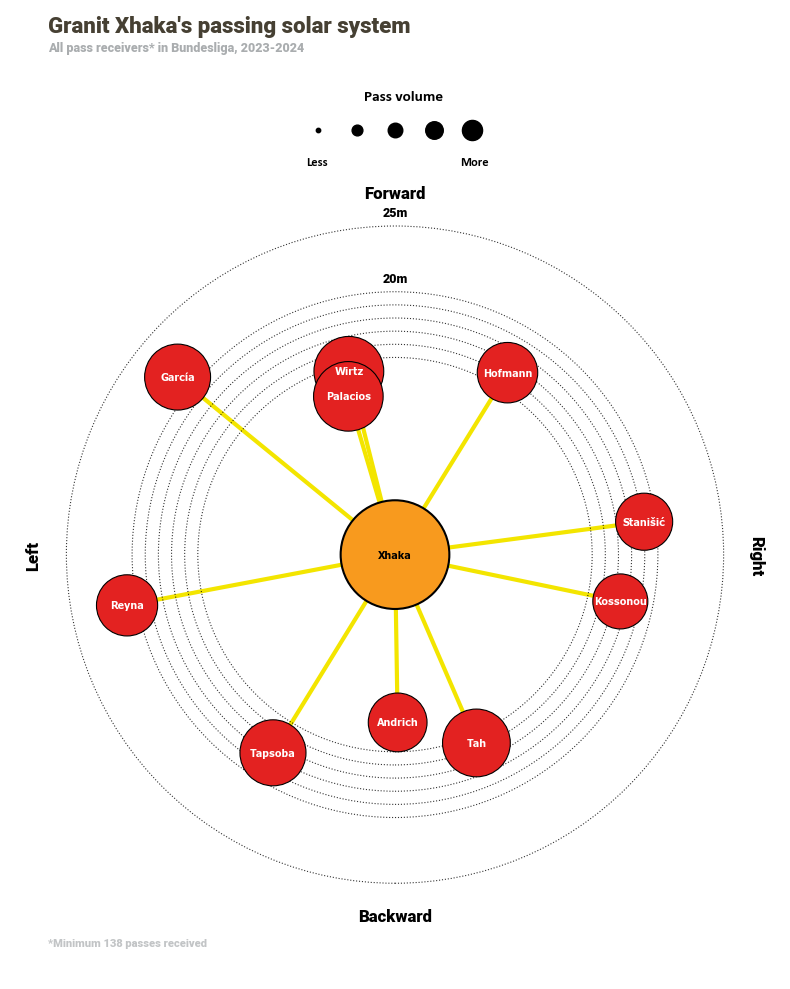

In [318]:
def player_passsolarsystem(df, player_name):
    # Create a figure with a specified size and background color
    fig = plt.figure(figsize=(8, 10), facecolor=background_color)

    # Define a GridSpec layout with 4 rows and 1 column
    # Height ratios: [0.25, 0.5, 4, 0.25] (title, legend, main chart, footer)
    gs = GridSpec(4, 1, figure=fig, height_ratios=[0.25, 0.5, 4, 0.25])

    # Title subplot (Row 0)
    ax_title = fig.add_subplot(gs[0, 0])
    # Add the main title for the chart
    ax_title.text(
        x=0.05, y=0.85,  # Position relative to the axis
        s=f'{player_name}\'s passing solar system',  # Main title text
        fontsize=16, color=text_color, fontproperties=font_props,  # Styling
        ha="left", va="top"  # Align to the top-left
    )
    # Add a subtitle with competition and season details
    ax_title.text(
        x=0.05, y=0.25,  # Position for the subtitle
        s=f'All pass receivers* in {competition}, {season}',  # Subtitle text
        fontsize=9, color=sec_color, fontproperties=font_props,  # Styling
        ha="left", va="top", alpha=0.7  # Slightly transparent
    )
    # Set fixed axis limits for a clean layout
    ax_title.set_xlim(0, 1)
    ax_title.set_ylim(0, 1)
    # Hide the axis frame and ticks for aesthetics
    ax_title.set_axis_off()

    # Legend subplot (Row 1)
    ax_legend = fig.add_subplot(gs[1, 0])
    # Add scatter points of varying sizes to represent pass volumes
    ax_legend.scatter(x=0.400, y=0.5, s=10, color='black')  # Smallest volume
    ax_legend.scatter(x=0.450, y=0.5, s=60, color='black')  # Slightly larger
    ax_legend.scatter(x=0.500, y=0.5, s=110, color='black')  # Medium volume
    ax_legend.scatter(x=0.550, y=0.5, s=160, color='black')  # Large volume
    ax_legend.scatter(x=0.600, y=0.5, s=210, color='black')  # Largest volume

    # Add a title for the legend
    ax_legend.text(
        x=0.46, y=0.85,  # Position for the legend title
        s='Pass volume', fontsize=11, fontname='Calibri', fontweight='bold'
    )
    # Add labels for the smallest and largest pass volumes
    ax_legend.text(
        x=0.385, y=0.1,  # Position for "Less"
        s='Less', fontsize=9, fontname='Calibri', fontweight='bold'
    )
    ax_legend.text(
        x=0.585, y=0.1,  # Position for "More"
        s='More', fontsize=9, fontname='Calibri', fontweight='bold'
    )
    # Set fixed axis limits for consistency
    ax_legend.set_xlim(0, 1)
    ax_legend.set_ylim(0, 1)
    # Hide the axis frame and ticks for aesthetics
    ax_legend.set_axis_off()

    # Main passing solar system chart (Row 2)
    ax_passsolarsystem = fig.add_subplot(gs[2, 0])
    # Call the `pass_solarsystem` function to create the main chart
    # Pass the DataFrame, figure, and axis to the function
    avg_passes = int(pass_solarsystem(df, fig=fig, ax=ax_passsolarsystem))

    # Footer subplot (Row 3)
    ax_footer = fig.add_subplot(gs[3, 0])
    # Add a footer with the minimum passes received
    ax_footer.text(
        x=0.05, y=0.95,  # Position for the footer text
        s=f'*Minimum {avg_passes} passes received',  # Footer text
        fontsize=8, color=sec_color, fontproperties=font_props,  # Styling
        ha="left", va="top", alpha=0.5  # Slightly transparent
    )
    # Set fixed axis limits for a clean layout
    ax_footer.set_xlim(0, 1)
    ax_footer.set_ylim(0, 1)
    # Hide the axis frame and ticks for aesthetics
    ax_footer.set_axis_off()

    # Automatically adjust spacing between subplots
    plt.tight_layout()
    # Display the final plot
    plt.show()

pass_df = process_data(player_name='Granit Xhaka')  # Process data for the player
player_passsolarsystem(pass_df, player_name = 'Granit Xhaka')  # Generate the passing solar system plot
